# Seattle Airbnb Data Analysis

In this notebook, I will analyze the [Seattle Airbnb dataset](https://www.kaggle.com/datasets/airbnb/seattle/data) from Kaggle. 

This project will follow and [CRoss Industry Standard Process for Data Mining - CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) which is consisted of the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modeling
5. Result Evaluation
6. Deployment

# 1. Business Understanding

Description

- Q1. 
- Q2. 
- Q3.

# 2. Data Understanding

## 2.1 Import libraries

In [178]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [179]:
def read_dataset(csv_file):
    df = pd.read_csv(csv_file)
    print("Number of rows and columns: ", df.shape)
    return df


def get_null_col(df):
    pd.set_option("display.precision", 2)
    null_col = df.columns[df.isna().sum()>0]
    col_null_val = df[null_col].isna().sum().sort_values(ascending=False)
    per_null_val = (df[null_col].isna().sum()/df.shape[0]*100).sort_values(ascending=False)
    nulls_df = pd.DataFrame(col_null_val, columns=['No. Nulls'])
    nulls_df['Nulls [%]'] = per_null_val
    print('Number of columns with missing data:', nulls_df.shape[0])
    return nulls_df

## 2.2 Load datasets

In [180]:
df_calendar = read_dataset('../data/calendar.csv')
df_calendar.head()

Number of rows and columns:  (1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [181]:
df_listings = read_dataset('../data/listings.csv')
df_listings.head()

Number of rows and columns:  (3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [182]:
df_reviews = read_dataset('../data/reviews.csv')
df_reviews.head()

Number of rows and columns:  (84849, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## 2.3 Explore datasets

### Calendar Dataset

In [183]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [184]:
get_null_col(df_calendar)

Number of columns with missing data: 1


,No. Nulls,Nulls [%]
price,459028,32.94


### Listings Dataset

In [185]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [186]:
get_null_col(df_listings)

Number of columns with missing data: 46


,No. Nulls,Nulls [%]
license,3818,100.00
square_feet,3721,97.46
monthly_price,2301,60.27
security_deposit,1952,51.13
weekly_price,1809,47.38
notes,1606,42.06
neighborhood_overview,1032,27.03
cleaning_fee,1030,26.98
transit,934,24.46
host_about,859,22.50


### Reviews Dataset

In [187]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB
None


In [188]:
get_null_col(df_reviews)

Number of columns with missing data: 1


,No. Nulls,Nulls [%]
comments,18,0.02


## 2.4 Exploratory Analysis

### Calendar Dataset

In [189]:
# Treatment of null values
# Clear and convert 'price' column
df_calendar['price'] = df_calendar['price'].str.replace('$', '').str.replace(',', '').astype(float)
df_calendar['price'] = df_calendar['price'].fillna(df_calendar['price'].median())

# Convert the available column to 1 or 0
df_calendar['available'] = df_calendar['available'].map({'t': 1, 'f': 0})

# Convert date column to datetime type
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

# Create new columns for month and year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['year'] = df_calendar['date'].dt.year

df_calendar.head(1)

,listing_id,date,available,price,month,year
0,241032,2016-01-04,1,85.0,1,2016


In [190]:
# Check for null values ​​after cleanup
null_counts_cleaned = df_calendar.isnull().sum()
print("Null values per column after cleaning:")
print(null_counts_cleaned)

Null values per column after cleaning:
listing_id    0
date          0
available     0
price         0
month         0
year          0
dtype: int64


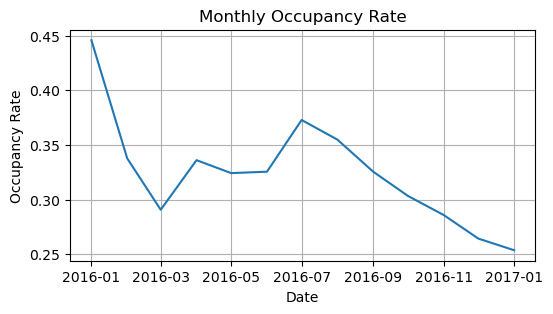

In [191]:
# Calculate monthly occupancy rate
occupancy_rate = df_calendar.groupby(['year', 'month', 'listing_id'])['available'].mean().reset_index()
occupancy_rate['occupancy_rate'] = 1 - occupancy_rate['available']
occupancy_rate = occupancy_rate.drop('available', axis=1)
monthly_occupancy = occupancy_rate.groupby(['year', 'month'])['occupancy_rate'].mean().reset_index()

# Create a date column from the year and month
monthly_occupancy['date'] = pd.to_datetime(monthly_occupancy[['year', 'month']].assign(day=1))

# Graph monthly occupancy rate
plt.figure(figsize=(6, 3))
sns.lineplot(data=monthly_occupancy, x='date', y='occupancy_rate')
plt.xlabel('Date')
plt.ylabel('Occupancy Rate')
plt.title('Monthly Occupancy Rate')
plt.grid(True)
plt.show()


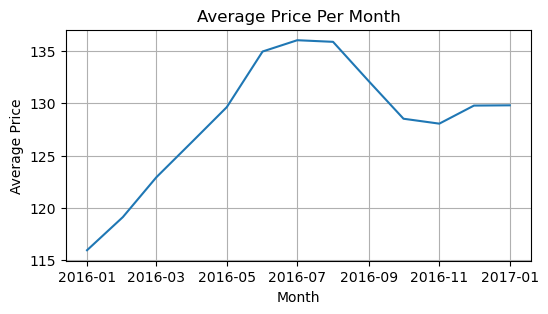

In [192]:
# Calculate monthly average price
avg_price_per_month = df_calendar.groupby(['year', 'month'])['price'].mean().reset_index()

# Create a date column from the year and month
avg_price_per_month['date'] = pd.to_datetime(avg_price_per_month[['year', 'month']].assign(day=1))

# Graph price trend
plt.figure(figsize=(6, 3))
sns.lineplot(data=avg_price_per_month, x='date', y='price')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.title('Average Price Per Month')
plt.grid(True)
plt.show()